In [216]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FastICA
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [217]:
#importing the file and defining the columns I am going to work with:
filePath = './brse.txt'
columnsName = ['YYMMMDD', '__east(m)', 'sig_e(m)']
site = pd.read_csv(filePath, usecols = columnsName, delimiter = '\s+')
site

,YYMMMDD,__east(m),sig_e(m)
0,10JUN12,-0.602588,0.000814
1,10JUN13,-0.604064,0.000805
2,10JUN14,-0.603825,0.000815
3,10JUN15,-0.602366,0.000796
4,10JUN16,-0.603291,0.000807
...,...,...,...
3053,19JUN30,-0.428062,0.000756
3054,19JUL01,-0.427384,0.000770
3055,19JUL02,-0.429304,0.000767
3056,19JUL03,-0.429537,0.000767


In [218]:
#changing the dtype of 'YYMMMDD':
site['YYMMMDD'] = pd.to_datetime(site['YYMMMDD'], format='%y%b%d')
site['YYMMMDD']

0      2010-06-12
1      2010-06-13
2      2010-06-14
3      2010-06-15
4      2010-06-16
          ...    
3053   2019-06-30
3054   2019-07-01
3055   2019-07-02
3056   2019-07-03
3057   2019-07-04
Name: YYMMMDD, Length: 3058, dtype: datetime64[ns]

In [219]:
#setting 'YYMMMDD' as index:
site.set_index('YYMMMDD', inplace = True)
site

,__east(m),sig_e(m)
YYMMMDD,,
2010-06-12,-0.602588,0.000814
2010-06-13,-0.604064,0.000805
2010-06-14,-0.603825,0.000815
2010-06-15,-0.602366,0.000796
2010-06-16,-0.603291,0.000807
...,...,...
2019-06-30,-0.428062,0.000756
2019-07-01,-0.427384,0.000770
2019-07-02,-0.429304,0.000767


In [220]:
#creating a new instance with a new period for the time series:
sitePeriodTime = site.loc['2010-06-12':'2019-07-04']
sitePeriodTime

,__east(m),sig_e(m)
YYMMMDD,,
2010-06-12,-0.602588,0.000814
2010-06-13,-0.604064,0.000805
2010-06-14,-0.603825,0.000815
2010-06-15,-0.602366,0.000796
2010-06-16,-0.603291,0.000807
...,...,...
2019-06-30,-0.428062,0.000756
2019-07-01,-0.427384,0.000770
2019-07-02,-0.429304,0.000767


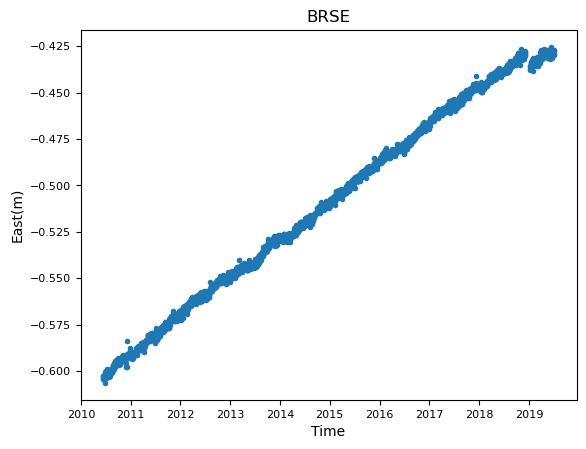

In [221]:
#checking the if the ts is stationarity for east:
plt.plot(sitePeriodTime.index, sitePeriodTime['__east(m)'], '.')
plt.title('BRSE')
plt.xlabel('Time')
plt.xticks(fontsize=8)
plt.ylabel('East(m)')
plt.yticks(fontsize=8)
plt.show()

In [222]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

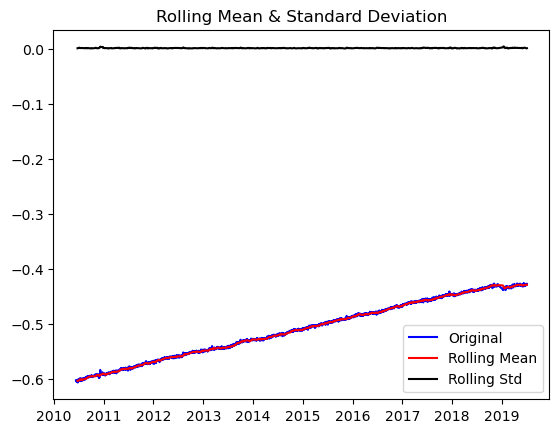

Results of Dickey-Fuller Test:
Test Statistic                   -1.431752
p-value                           0.566963
#Lags Used                       15.000000
Number of Observations Used    3042.000000
Critical Value (1%)              -3.432501
Critical Value (5%)              -2.862491
Critical Value (10%)             -2.567276
dtype: float64


In [223]:
test_stationarity(sitePeriodTime['__east(m)'])

In [224]:
tsLogE = np.log1p(sitePeriodTime['__east(m)'])
tsLogE

YYMMMDD
2010-06-12   -0.922782
2010-06-13   -0.926503
2010-06-14   -0.925899
2010-06-15   -0.922223
2010-06-16   -0.924552
                ...   
2019-06-30   -0.558725
2019-07-01   -0.557540
2019-07-02   -0.560899
2019-07-03   -0.561307
2019-07-04   -0.557189
Name: __east(m), Length: 3058, dtype: float64

In [225]:
tsLogE_df = pd.DataFrame(tsLogE, index=tsLogE.index)
tsLogE_df

,__east(m)
YYMMMDD,
2010-06-12,-0.922782
2010-06-13,-0.926503
2010-06-14,-0.925899
2010-06-15,-0.922223
2010-06-16,-0.924552
...,...
2019-06-30,-0.558725
2019-07-01,-0.557540
2019-07-02,-0.560899


In [226]:
tsLogDiffE = tsLogE - tsLogE.shift()
tsLogDiffE

YYMMMDD
2010-06-12         NaN
2010-06-13   -0.003721
2010-06-14    0.000603
2010-06-15    0.003676
2010-06-16   -0.002329
                ...   
2019-06-30   -0.000009
2019-07-01    0.001185
2019-07-02   -0.003359
2019-07-03   -0.000408
2019-07-04    0.004118
Name: __east(m), Length: 3058, dtype: float64

In [227]:
tsLogDiffE.dropna(inplace = True)
tsLogDiffE

YYMMMDD
2010-06-13   -0.003721
2010-06-14    0.000603
2010-06-15    0.003676
2010-06-16   -0.002329
2010-06-17   -0.003877
                ...   
2019-06-30   -0.000009
2019-07-01    0.001185
2019-07-02   -0.003359
2019-07-03   -0.000408
2019-07-04    0.004118
Name: __east(m), Length: 3057, dtype: float64

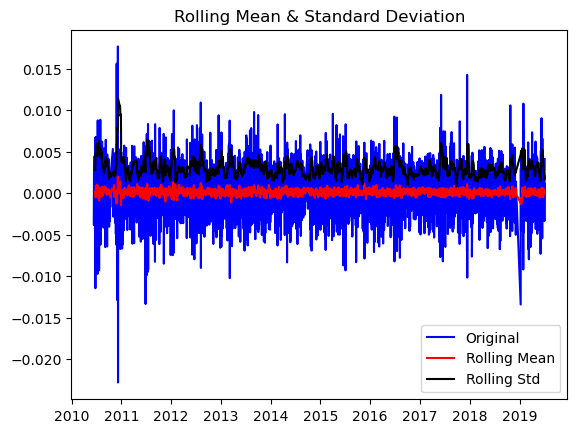

Results of Dickey-Fuller Test:
Test Statistic                  -21.101350
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    3042.000000
Critical Value (1%)              -3.432501
Critical Value (5%)              -2.862491
Critical Value (10%)             -2.567276
dtype: float64


In [228]:
test_stationarity(tsLogDiffE)

In [229]:
tsLogDiffE_df = pd.DataFrame(tsLogDiffE, index=tsLogDiffE.index)
tsLogDiffE_df

,__east(m)
YYMMMDD,
2010-06-13,-0.003721
2010-06-14,0.000603
2010-06-15,0.003676
2010-06-16,-0.002329
2010-06-17,-0.003877
...,...
2019-06-30,-0.000009
2019-07-01,0.001185
2019-07-02,-0.003359


In [230]:
limiarZ = 1.0
tsLogDiffE_noOut = tsLogDiffE_df[(np.abs(tsLogDiffE_df-tsLogDiffE_df.mean()) 
                                              < limiarZ*tsLogDiffE_df.std())]
tsLogDiffE_noOut

,__east(m)
YYMMMDD,
2010-06-13,NaN
2010-06-14,0.000603
2010-06-15,NaN
2010-06-16,-0.002329
2010-06-17,NaN
...,...
2019-06-30,-0.000009
2019-07-01,0.001185
2019-07-02,NaN


In [231]:
#removing the rows with missing values
tsLogDiffE_noOut.dropna(inplace=True)
tsLogDiffE_noOut

,__east(m)
YYMMMDD,
2010-06-14,0.000603
2010-06-16,-0.002329
2010-06-18,0.002378
2010-06-20,-0.002695
2010-06-21,-0.000146
...,...
2019-06-27,0.001681
2019-06-29,0.000780
2019-06-30,-0.000009


from statsmodels.tsa.seasonal import seasonal_decompose

#data frame before checking the outliers
decompositionE = seasonal_decompose(tsLogDiffE_df, period=365)
trendE = decompositionE.trend
seasonalE = decompositionE.seasonal
residualE = decompositionE.resid

plt.subplot(411) 
plt.plot(tsLogDiffE_df, label='Orig.') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trendE, label='T') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonalE,label='S') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residualE, label='R') 
plt.legend(loc='best') 
plt.tight_layout()

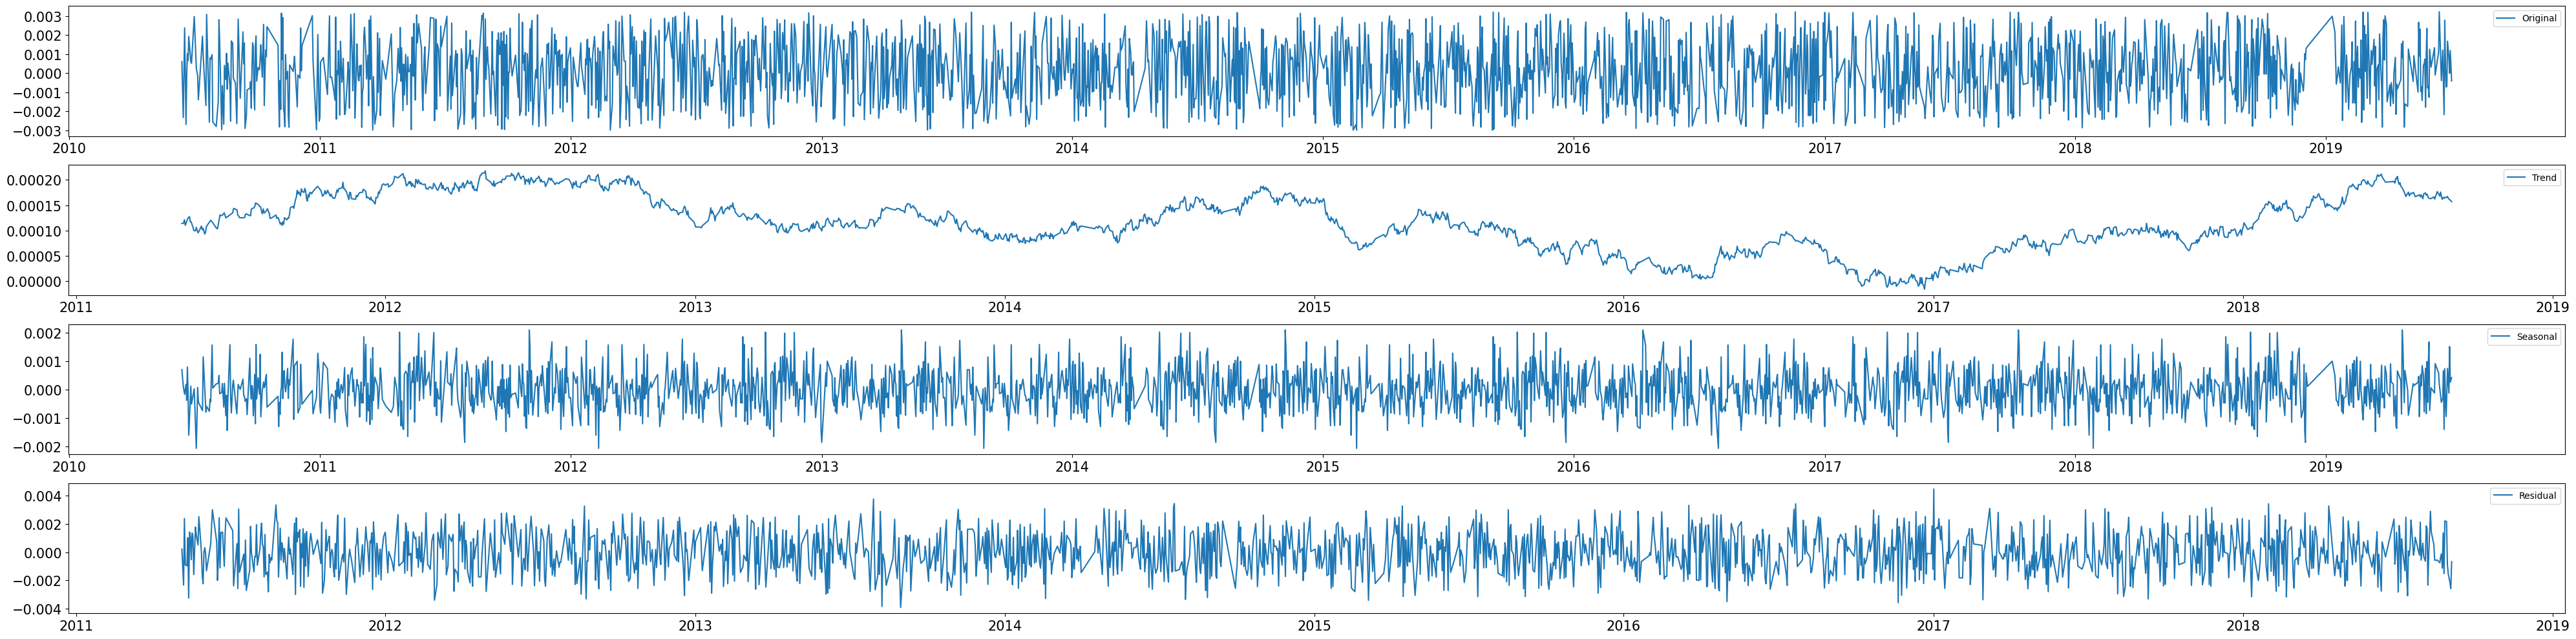

In [232]:
#data frame with outliers removed 
decompositionE_outRem = seasonal_decompose(tsLogDiffE_noOut, period=365)
trendE_outRem = decompositionE_outRem.trend
seasonalE_outRem = decompositionE_outRem.seasonal
residualE_outRem = decompositionE_outRem.resid

fig=plt.figure(figsize=(40,10))

plt.subplot(411) 
plt.plot(tsLogDiffE_noOut, label='Original') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(412) 
plt.plot(trendE_outRem, label='Trend') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(413) 
plt.plot(seasonalE_outRem,label='Seasonal') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(414) 
plt.plot(residualE_outRem, label='Residual') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.tight_layout()

fl = 'brse_decomposition_east.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

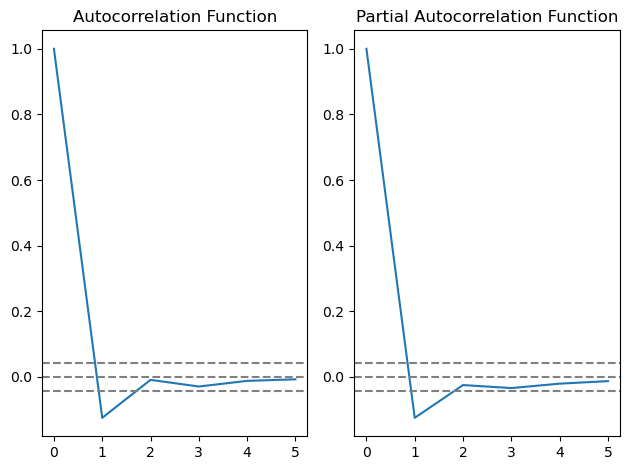

In [233]:
#ACF and PACF plots - rolling mean:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(tsLogDiffE_noOut, nlags=5)
lag_pacf = pacf(tsLogDiffE_noOut, nlags=5, method='ols')

#Plot ACF (q -> model MA): 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF (p -> model AR): 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.tight_layout()

In [234]:
#converting the index to datetime
tsLogDiffE_df.index = pd.to_datetime(tsLogDiffE_df.index)
tsLogDiffE_noOut2.index = pd.to_datetime(tsLogDiffE_noOut2.index)
tsLogDiffE_noOut.index = pd.to_datetime(tsLogDiffE_noOut.index)
tsLogE_df.index = pd.to_datetime(tsLogE_df.index)

#making sure that the index is in order
tsLogDiffE_df.sort_index(inplace=True)
tsLogDiffE_noOut2.sort_index(inplace=True)
tsLogDiffE_noOut.sort_index(inplace=True)
tsLogE_df.sort_index(inplace=True)

#setting the frequency as daily
tsLogDiffE_df = tsLogDiffE_df.asfreq('D')
tsLogDiffE_noOut2 = tsLogDiffE_noOut2.asfreq('D')
tsLogDiffE_noOut = tsLogDiffE_noOut.asfreq('D')
tsLogE_df = tsLogE_df.asfreq('D')

In [235]:
from statsmodels.tsa.arima.model import ARIMA

In [236]:
tsLogDiffE_df.rename(columns={'__east(m)':'east(m)'}, inplace=True)

In [237]:
print(tsLogDiffE_df['east(m)'])

YYMMMDD
2010-06-13   -0.003721
2010-06-14    0.000603
2010-06-15    0.003676
2010-06-16   -0.002329
2010-06-17   -0.003877
                ...   
2019-06-30   -0.000009
2019-07-01    0.001185
2019-07-02   -0.003359
2019-07-03   -0.000408
2019-07-04    0.004118
Freq: D, Name: east(m), Length: 3309, dtype: float64


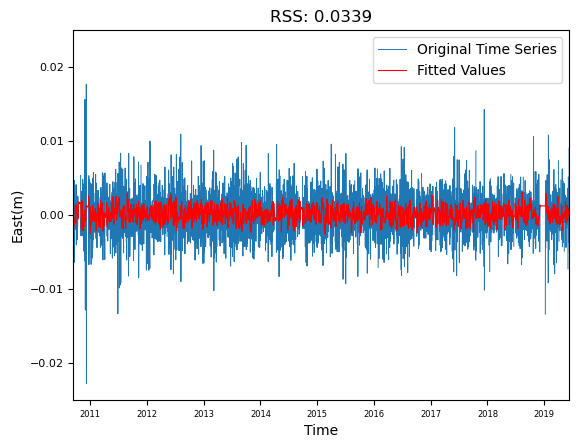

In [238]:
#model AR (Auto-Regressive) -> Plot PACF (p = 1)
modelE_AR = ARIMA(tsLogDiffE_noOut, order=(2, 1, 0))  
resultsE_AR = modelE_AR.fit()
plt.plot(tsLogDiffE_df,  label='Original Time Series', linewidth = 0.7)
plt.plot(resultsE_AR.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_AR = resultsE_AR.fittedvalues - tsLogDiffE_df['east(m)']
rss_AR = np.sum(residuals_AR**2, axis=0)

#Ensure rss is a scalar (float)
#rss_scalar = float(rss.iloc[0]) 

# Show the plot
plt.title(f'RSS: {rss_AR:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2019-06-13'))
plt.ylabel('East(m)')
plt.ylim(-0.025,0.025)
plt.yticks(fontsize=8)
plt.show()

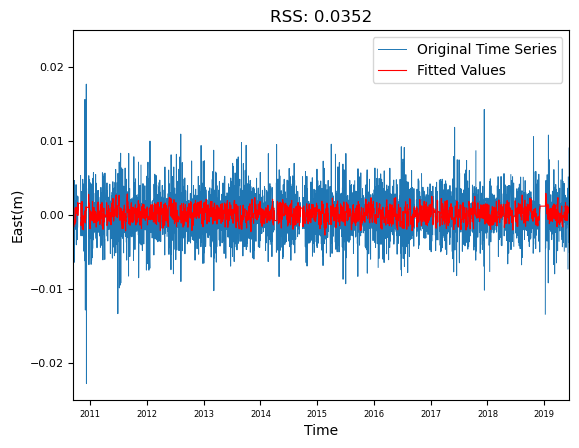

In [239]:
#model MA (Moving Averages) -> Plot ACF (q = 1)
model_MA = ARIMA(tsLogDiffE_noOut, order=(0, 1, 1))  
results_MA = model_MA.fit()  
plt.plot(tsLogDiffE_df, label='Original Time Series', linewidth = 0.7)
plt.plot(results_MA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_MA = results_MA.fittedvalues - tsLogDiffE_df['east(m)']
rss_MA = np.sum(residuals_MA**2, axis=0)


plt.title(f'RSS: {rss_MA:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2019-06-13'))
plt.ylabel('East(m)')
plt.ylim(-0.025,0.025)
plt.yticks(fontsize=8)
plt.show()

In [240]:
from scipy import interpolate

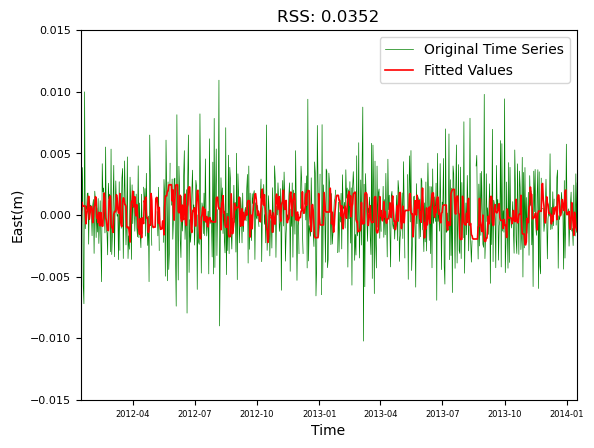

In [243]:
#combined - model ARIMA  p = 1 and q = 1:
#Auto-Regressive Integrated Moving Averages
model_ARIMA = ARIMA(tsLogDiffE_noOut, order=(1, 1, 1))  
results_ARIMA = model_ARIMA.fit()  

plt.plot(tsLogDiffE_df, color='green', label='Original Time Series', linewidth = 0.5)
plt.plot(results_ARIMA.fittedvalues,color='red', label='Fitted Values', linewidth= 1.2)

# Calculate Residual Sum of Squares (RSS)
residuals_ARIMA = results_ARIMA.fittedvalues - tsLogDiffE_df['east(m)']
rss_ARIMA = np.sum(residuals_ARIMA**2, axis=0)

plt.title(f'RSS: {rss_MA:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.ylabel('East(m)')
plt.ylim(-0.015,0.015)
plt.yticks(fontsize=8)

plt.show()

#Plot rep: 
plt.subplot(121) 
plt.plot(tsLogDiffE_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2011-03-15'))
plt.title('Outliers Replaced')

#Plot del: 
plt.subplot(122)
plt.plot(tsLogDiffE_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA_outDel.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2020-06-13'))
plt.title('Outliers Removed')
plt.tight_layout()

# Smooth Fitted Values using a Moving Average
window_size = 4  # You can adjust the window size as needed
smoothed_values = results_ARIMA.fittedvalues.rolling(window=window_size).mean()
plt.plot(tsLogDiffE_noOut.index, smoothed_values, color='blue', label=f'Smoothed Values (Window={window_size})', linewidth=0.9)
plt.xlim(pd.Timestamp('2011-05-15'), pd.Timestamp('2012-05-15'))
plt.show()

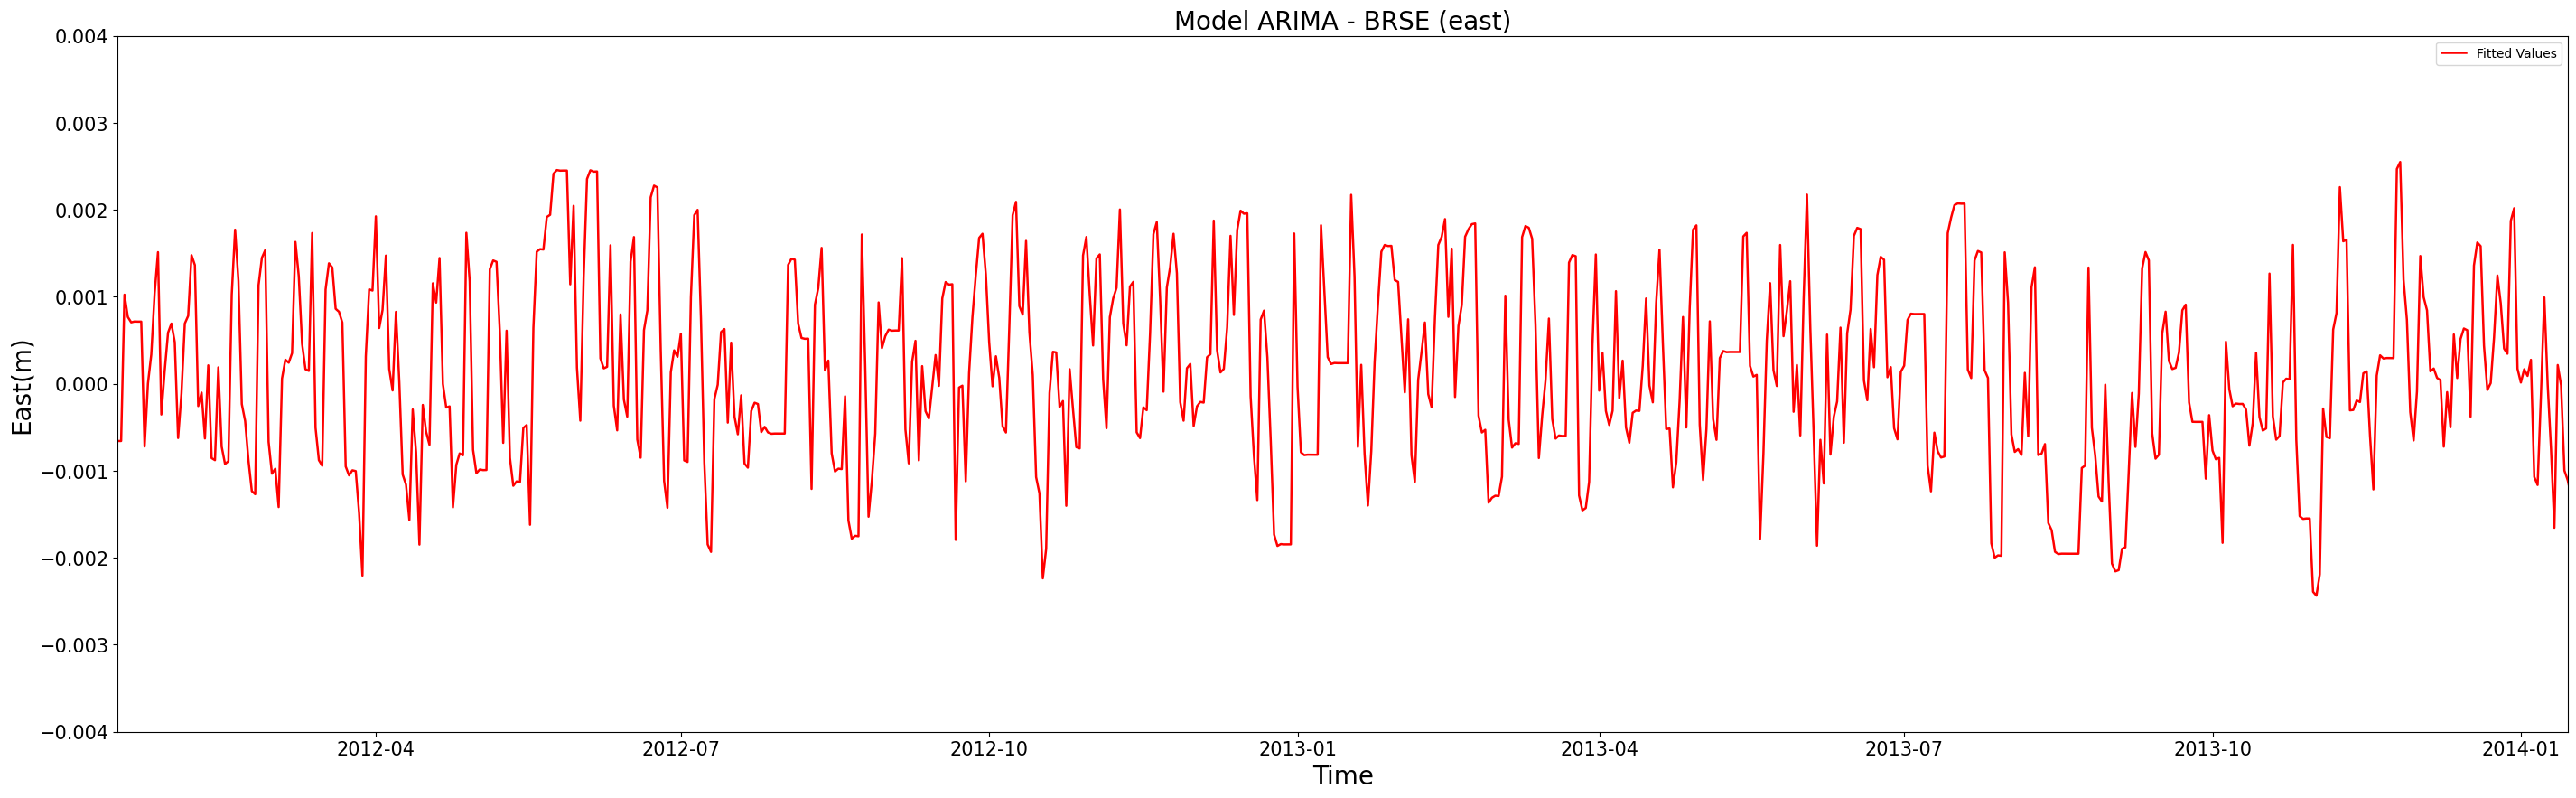

In [247]:
fig=plt.figure(figsize=(35,10))
#plt.plot(tsLogDiffE_df, color='green', label='Original Time Series', linewidth = 1.)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth = 1.8)
#plt.plot(results_ARIMA.fittedvalues,color='red', label='model 1', linewidth= 1.2)

plt.title('Model ARIMA - BRSE (east)', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.ylabel('East(m)', fontsize=20)
plt.ylim(-0.004,0.004)
plt.yticks(fontsize=15)
plt.legend(loc='best') 

fl = 'brse_arima_east.svg'
f = io.BytesIO()
#plt.savefig(fl, format="svg")

plt.show()

# 